In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from ipywidgets import interact
from tqdm.notebook import tqdm

from eventbee import chronogram

# Load ready-made event dataframe

In [12]:
# Load full dataframe of events
full_df = pd.read_parquet('~/plotbee/notebooks/one_week_analysis_800__tracks__with_labelbee_videoid.parquet')
full_df.shape

(1958893, 27)

In [ ]:
# Select tag ids that have 5 events or more
id_counts = full_df['track_tagid'].dropna().astype(int).value_counts().rename('counts')
tids = id_counts[id_counts>=5].index
tids = np.sort(tids).astype(int)

# Custom tids
#tids = np.array([1609,1621],dtype=int)

tids

array([ 197,  508,  515,  516,  517,  638,  661,  677,  930,  986, 1109,
       1230, 1237, 1361, 1404, 1407, 1415, 1607, 1609, 1621, 1651, 1652,
       1698, 1722, 1780, 1786, 1797, 1900, 1979, 2258, 2487])

In [ ]:
# Restrict data to selected tag ids
vdf = full_df[full_df.track_tagid.isin(tids)].copy()
vdf['track_tagid'] = vdf['track_tagid'].astype(int) # Convert to int after removing the NaNs
vdf.shape

(5024, 27)

## Explore event dataframe content

In [19]:
#full_df.columns
list(full_df.dtypes.astype(str).items())

[('track_id', 'int64'),
 ('track_pollen_score', 'float64'),
 ('track_shape', 'object'),
 ('track_event', 'object'),
 ('track_tagid', 'float64'),
 ('track_hastag', 'bool'),
 ('track_startframe', 'int64'),
 ('track_startx', 'int64'),
 ('track_starty', 'int64'),
 ('track_starta', 'float64'),
 ('track_endframe', 'int64'),
 ('track_endx', 'int64'),
 ('track_endy', 'int64'),
 ('track_enda', 'float64'),
 ('track_length', 'int64'),
 ('datetime', 'datetime64[us]'),
 ('track_starttime', 'datetime64[us]'),
 ('track_endtime', 'datetime64[us]'),
 ('pollen', 'bool'),
 ('entering', 'bool'),
 ('leaving', 'bool'),
 ('entering_leaving', 'bool'),
 ('walking', 'bool'),
 ('video_name', 'object'),
 ('labelbee_videoid', 'int64'),
 ('video_filename', 'object'),
 ('video_seq', 'int64')]

In [8]:
full_df.track_shape.unique()

array(['inside', 'ramp-inside', 'outside_inside', 'ramp_ramp', 'noise',
       'inside_ramp', 'ramp_outside', 'outside_ramp', 'outside',
       'inside_out', 'outside_outside', 'inside_inside', None],
      dtype=object)

# Display event chronogram

## Select which tagids to display

## Simple inline plot

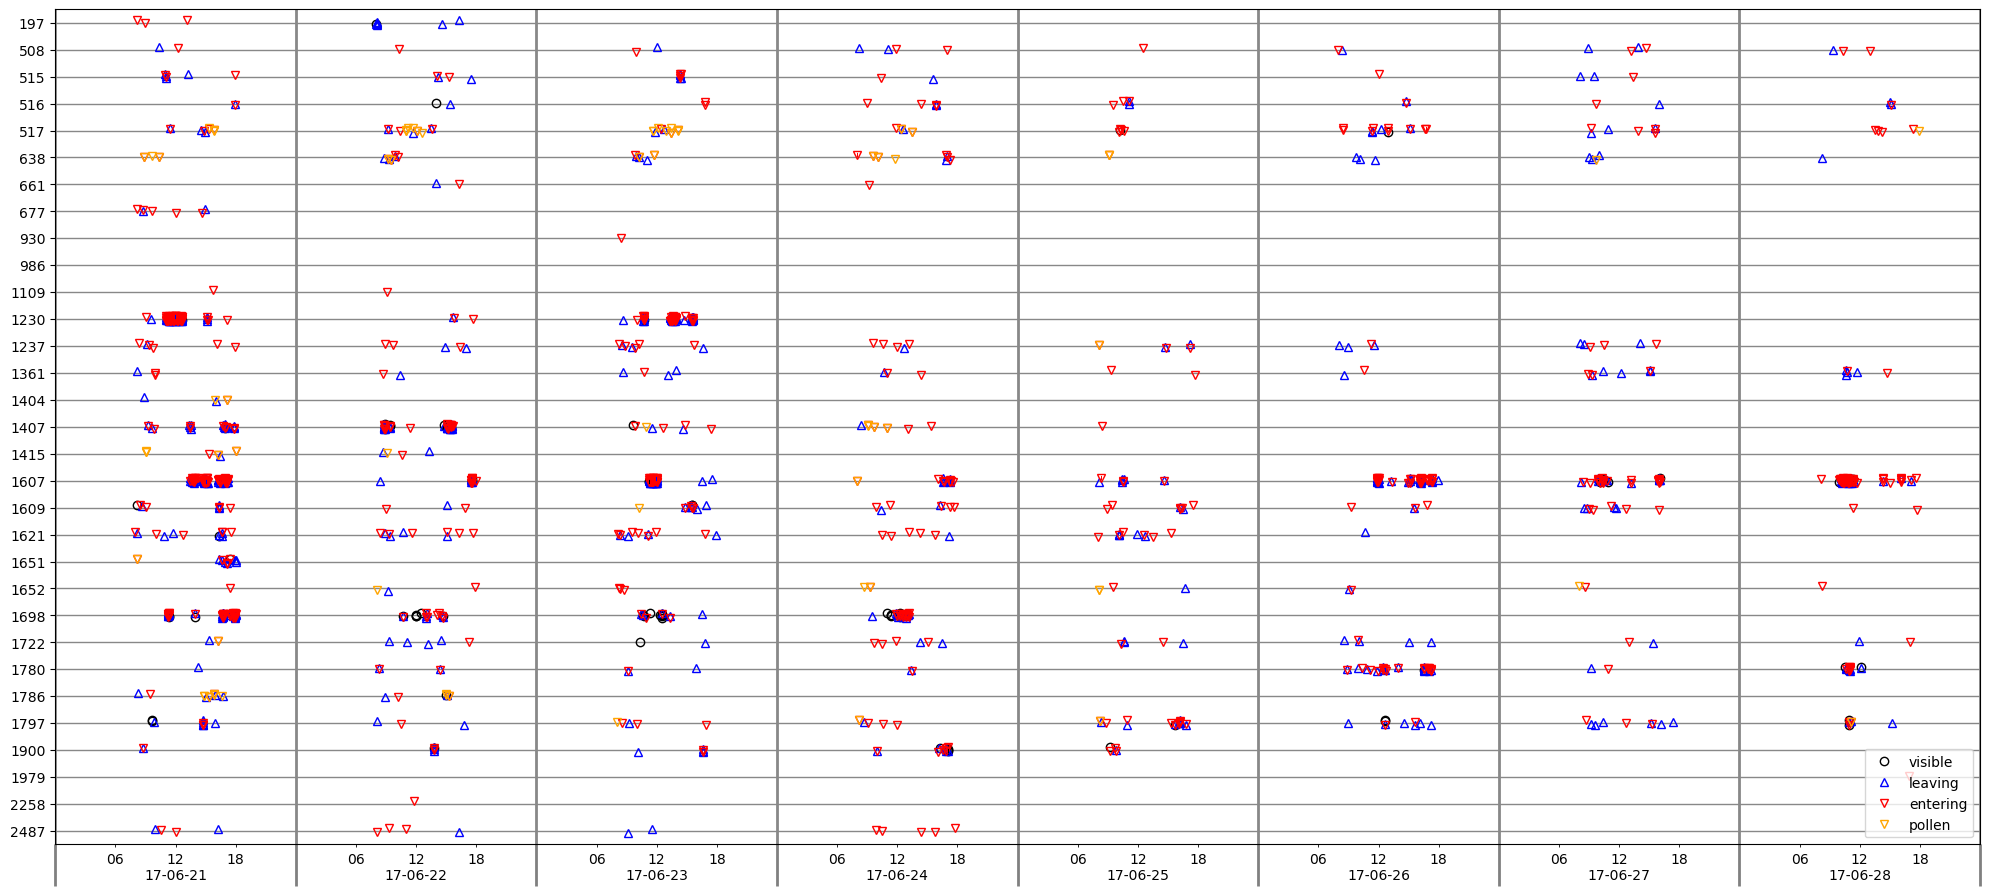

In [47]:
%matplotlib inline

from eventbee.chronogram import plot_activities_df, format_multiday

fig,axes = plt.subplots(1,1,figsize=(20,10))
plt.sca(axes)
plot_activities_df(vdf, plot_interval=True, tagids=None, leaving_symbol = '^', entering_symbol = 'v');
format_multiday()
plt.xlim(pd.to_datetime('2017-06-21 00:00'),pd.to_datetime('2017-06-29 00:00'))
plt.tight_layout();

plt.savefig("tagged_bees_activities.png")

## Widget based event plot (with click callback)

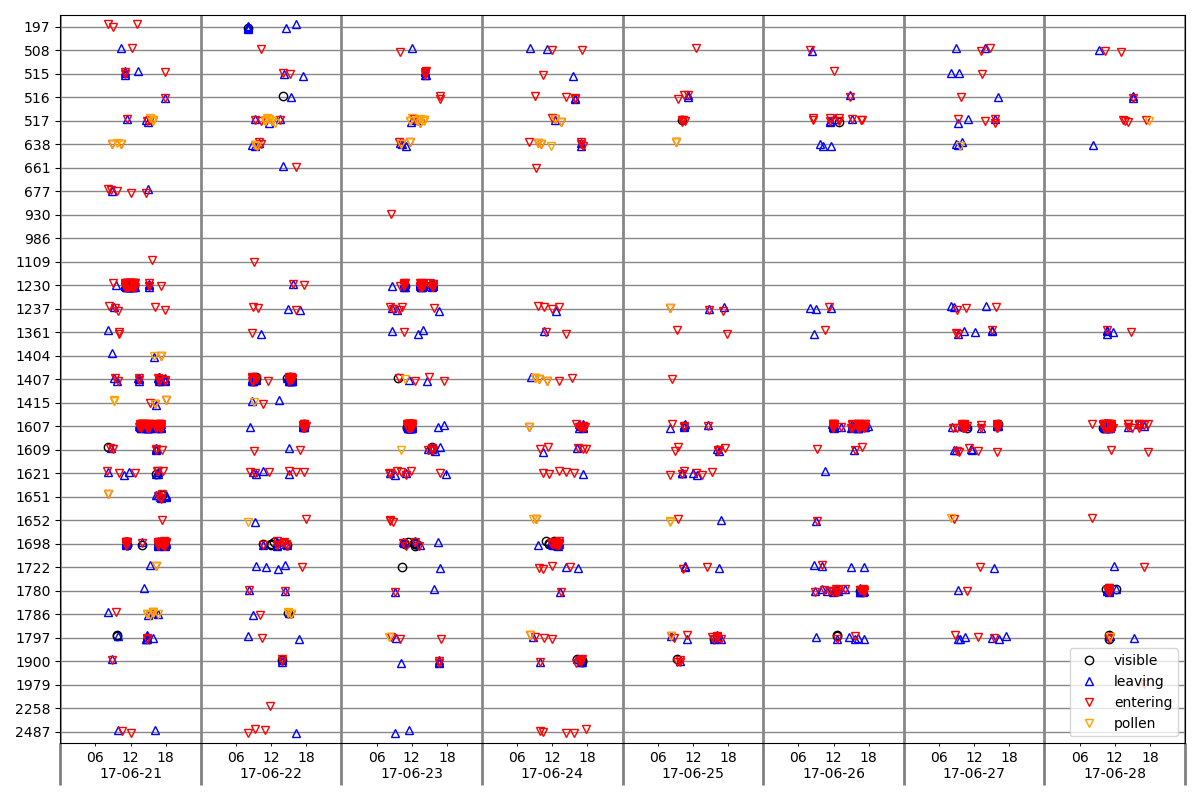

In [49]:
%matplotlib widget

# 1. Create an activity chronogram

from eventbee.chronogram import plot_activities_df, format_multiday

fig,axes = plt.subplots(1,1,figsize=(12,8))
plt.sca(axes)
plot_activities_df(vdf, plot_interval=True, tagids=None, leaving_symbol = '^', entering_symbol = 'v');
plt.xlim(pd.to_datetime('2017-06-21 00:00'),pd.to_datetime('2017-06-29 00:00'))
format_multiday()
plt.tight_layout();


# 2. Define and register click callback

from eventbee.chronogram import register_chronogram_event_click

def item_clicked_cb(clicked_item):
    # Example calbback to react to click on chronogram
    # Hardcoded axes needs to have axes.activity_data_ defined
    if (clicked_item is None): return
    axes.plot(clicked_item.track_starttime, axes.activity_data_['rmap'][clicked_item.track_tagid], 'k*')
    print('Event track_tagid=',clicked_item.track_tagid, ' track_starttime=',clicked_item.track_starttime)
    # Could do custom reaction to click

click_cb_id = register_chronogram_event_click(fig, vdf, axes, item_clicked_cb)

# Link to labelbee video

In [25]:
def labelbee_url(event):
    videoid = event['labelbee_videoid']
    frame = event['track_startframe']
    url = f"http://136.145.54.85/webapp/labelbee/gui#video_id={videoid}&frame={frame}" 
    return url
    
event_loc = 120607
event = full_df.loc[event_loc]
print(f"Event {event_loc}: ",labelbee_url(event))

Event 120607:  http://136.145.54.85/webapp/labelbee/gui#video_id=16141&frame=67706


In [26]:
full_df.labelbee_videoid.unique()

array([10939, 15072, 14393, 14803, 13079, 13490, 16141, 16035, 14469,
       13361, 15210, 11507, 12386, 15502, 15444, 13085, 12125, 11500,
       12950, 15683, 12454, 15398, 12718, 14693, 12558, 16249, 15022,
       13737, 16031, 10997, 12672, 12825, 15501, 15423, 11471, 14120,
       11431, 15410, 12508, 12409, 15388, 11183, 12139, 11269, 13893,
       11586, 12411, 12556, 12704, 11210, 14090, 14045, 15415, 15204,
       15932, 16152, 12979, 12342, 15421, 13592, 14424, 14174, 15633,
       11747, 11617, 12262, 15676, 15023, 15736, 12994, 11544, 13875,
       12265, 13272, 15080, 15661, 15160, 14442, 11037, 11282])

# Display of events in video in notebook

In [ ]:
# General imports
from decord import VideoReader
from decord import cpu, gpu
import ipywidgets
import PIL

## Manual display of one event

In [36]:
from eventbee.video_plot import load_frame, plot_track

,3606
track_id,3606
track_pollen_score,0.000543
track_shape,outside_ramp
track_event,entering
track_tagid,197.0
track_hastag,True
track_startframe,9509
track_startx,1476
track_starty,980
track_starta,355.763605


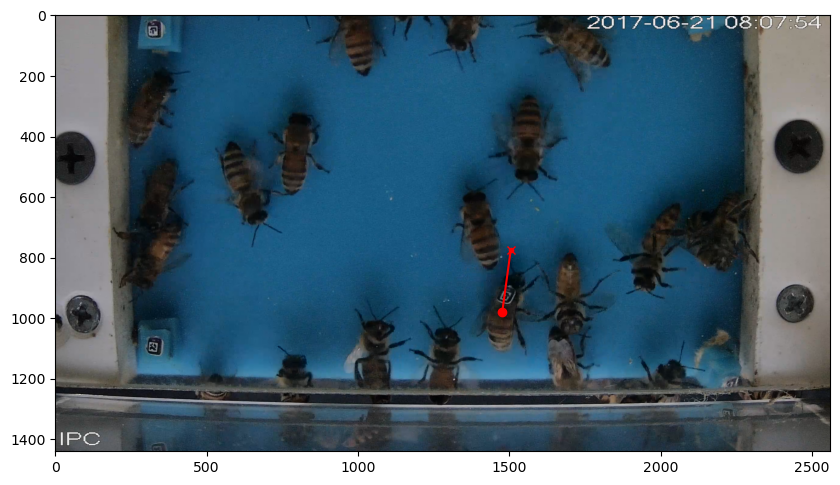

In [38]:
# Visualize one event manually
%matplotlib inline

#event = full_df.iloc[10]
event = full_df.loc[3606]

with pd.option_context('display.max_colwidth', 200):
    display(pd.DataFrame(event))

fig = plt.figure(figsize=(10,6))
frame = event.track_startframe
plot_track(event, frame=frame, videoreader=None, ax=None);

## Manual display of one event with frame navigation

interactive(children=(IntSlider(value=195, continuous_update=False, description='frame', max=71999), IntSlider…

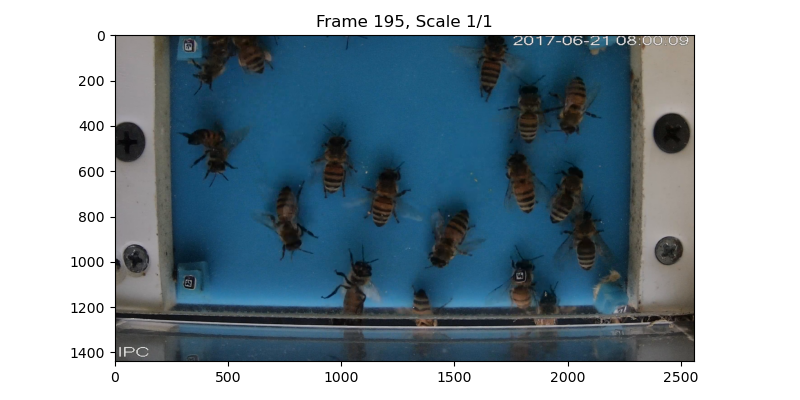

In [14]:
%matplotlib widget
# IMPORTANT: matplotlib widget requires `ipympl` installed in kernel environment with a compatible version to jupyterlab server environment.
# Check this if slider widgets do not appear, or an error about widgets is returned.
# See: https://matplotlib.org/ipympl/installing.html

from eventbee.video_plot import GUI_PlotVideo

# Pick up an event to display
event = vdf.iloc[0]

gui = GUI_PlotVideo(event['video_filename'], event['track_startframe']);

In [1]:
vdf.iloc[1000]

NameError: name 'vdf' is not defined

In [15]:
gui.set_video(vdf.iloc[1000]['video_filename'])

: 

: 

: 

## Selection of events from vdf dataframe

In [25]:
def event_name(row):
    noise = False
    event_name = ""
    if row.pollen:            event_name += "pollen"
    if row.entering:          event_name += "entering"
    if row.leaving:           event_name += "leaving"
    if row.walking:           event_name += "walking"
    if row.entering_leaving:  event_name += "entering_leaving"
    if event_name == "":
        event_name += "noise"
        noise = True
        
    event_name += " - {}".format(row.datetime)
    return noise, event_name

In [26]:
%matplotlib widget
from ipywidgets import *
from collections import namedtuple
import time
from functools import lru_cache
#from skimage.transform import resize, rescale
import PIL

# vdf must be defined previously

# Create one figure
plt.ioff()
fig = plt.figure(figsize=(8,4))
plt.ion()
fig.canvas.header_visible = False
fig.clear()
ax = fig.add_subplot(111)
ax.clear()
ax.imshow(np.array([[0,1]]))
ax.set_title(f"Initialized")
fig.set_tight_layout(True)

from dataclasses import dataclass

@dataclass
class Glob:
    vr = None

glob = Glob()

def get_event_options(vdf, tid):
    options = list()
    for i, row in vdf[vdf.track_tagid == tid].iterrows():
        noise, name = event_name(row)
#         if not noise:
        D = dict(row)
        D['loc']=i
        options.append((name, D))
    return options

# Widgets
tids_widget = Dropdown(options = tids)
options = get_event_options(vdf, tids_widget.value)
events_widget = Dropdown(options=options)
frame_slider = widgets.IntSlider(min=0, max=10000, step=1, value=0, continuous_update=False)
scale_widget = Dropdown(options=[0,1,2,3,4,5,6])

debug_view = widgets.Output(layout=Layout(height='200px', overflow_y='auto'))
event_view = widgets.Output(layout=Layout(height='400px', max_width='600px', overflow_x='auto', overflow_y='auto'))


@lru_cache(maxsize=20)
def get_frame(frame):
    img = glob.vr[frame].asnumpy()
    glob.vr.seek(0)
    return img

def imscale(img, s):
    h,w,_ = img.shape
    return np.asarray(PIL.Image.fromarray(img).resize((int(w * s), int(h * s))))
        
def debug(clear_output=False):
    def wrapped_fun(fn):
        def wraps(*args, **kwargs):
            with debug_view:
                if (clear_output):
                    debug_view.clear_output()
                fn(*args, **kwargs)
        return wraps
    return wrapped_fun

@debug(clear_output=True)
def tid_changed(change):
    ctid = change.new
    print('tid_changed',ctid)
    options = get_event_options(vdf, ctid)
    events_widget.options = options

@debug()
def event_changed(change):
    event = change.new
    print('event_changed',event)
    
    eventrow = vdf.loc[event['loc']]
    
    with event_view:
        event_view.clear_output()
        with pd.option_context('display.max_colwidth', 200):
            display(pd.DataFrame(eventrow))
            print(eventrow['video_filename'])

    print('LOADING VIDEO...')
    tic = time.perf_counter()
    glob.vr = VideoReader(event['video_filename'], ctx=cpu(0))
    toc = time.perf_counter()
    print(f'LOADED. ({toc-tic:.2f}s)')
    glob.vr.seek(0)
    get_frame.cache_clear()
    
    ax.clear()

    #frameimg = glob.vr[0].asnumpy()
    #ax.imshow(imscale(frameimg*0, 1.0)) # Dummy
    
    frame = event["track_startframe"]
    frame_slider.min = -10000
    frame_slider.max = frame+100
    frame_slider.min = frame-100
    frame_slider.value = frame
    
    redraw()

@debug()
def frame_changed(change):
    frame = change.new
    print('frame_changed',frame)
    redraw()

@debug()
def redraw(change=None):
    event, frame = events_widget.value, frame_slider.value
    #print(event, frame)
    resolution_level = scale_widget.value
    scale = 2**resolution_level
    
    print('REDRAW', frame, resolution_level)
    loc = event['loc']
    
    #plot_track(event, frame, vr, ax)
    tic = time.perf_counter()
    frameimg = get_frame(frame)
    toc = time.perf_counter()
    print(f'TOOK {toc-tic:.2f}s')

    if len(ax.images)==0:
        ax.clear()
        ax.imshow(imscale(frameimg, 1.0/scale), extent=[0,frameimg.shape[1],frameimg.shape[0],0])
        #ax.plot([0,3],[6,4],'r-')

        # OVERLAY TRACK BEGIN/END
        start_x = event["track_startx"] 
        start_y = event["track_starty"]
        end_x = event["track_endx"]
        end_y = event["track_endy"]

        #ax.plot( (start_x,end_x), (start_y,end_y), 'r.-' )
        #ax.plot( (start_x,), (start_y,), 'ro' )
        #ax.plot( (end_x,), (end_y,), 'rx' )
        #ax.text( start_x,start_y, 'S', color='red', fontsize=24.0, horizontal_alignemnt='center' )
        ax.arrow( start_x, start_y, end_x-start_x, end_y-start_y, color='red', length_includes_head=True, head_width=40.0 )
    else:
        ax.images[0].set_data( imscale(frameimg, 1.0/scale) )
    ax.set_title(f"Event {loc}, Frame {frame}")
    
    #fig.canvas.draw()
    
#interact(f, tid=tids_widget, event=events_widget, frame=frame_slider);

tids_widget.observe(tid_changed, names="value")
events_widget.observe(event_changed, names="value")
frame_slider.observe(frame_changed, names="value")
scale_widget.observe(redraw, names="value")

scene = VBox([ 
                HBox([tids_widget, events_widget]),
                HBox([frame_slider, scale_widget]),
                HBox([VBox([fig.canvas], layout=Layout(border='1px solid black', width='100%',overflow_x='auto',overflow_y='auto')), 
                      VBox([event_view], layout=Layout(border='1px solid black', width='100%',overflow_x='auto',overflow_y='auto')) ]),
                HBox([debug_view], layout=Layout(border='1px solid black'))
             ], layout=Layout(width='100%',overflow_x='auto'))
display(scene)

from traitlets.utils.bunch import Bunch
tid_changed(Bunch(new=tids[0]))
event_changed(Bunch(new=events_widget.options[0][1]))